<a href="https://colab.research.google.com/github/MRMRMRMAY/Advanced-Software-Analysis-202102/blob/main/Term%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import sys

import numpy as np
from numpy import argwhere as findIdx
from scipy.spatial import distance_matrix, distance
from itertools import accumulate
from bisect import bisect_left
from copy import deepcopy
from statistics import mean, stdev
from math import exp
from time import process_time


K = 100 # The number of nodes, cannot be change
M = 50 # The required number of cluster
a = 0.5 # alpha: the ratio of the elitist to the next generation population
pro_mutation = 0.2 # The probability of executing mutation
size_pop = 1000 # The size of population for each generation
round_crossover = int(size_pop/4) # The rounds of crossover
r = 100 # The radius of cluster region
max_interval = 500 # The maximum interval between old and new best-so-far results.
input_fName = "./centroid_blobs_ILP.txt";
out_fName = "./centers_second.txt";

class Ind:
    # initialize the attributes
    def __init__(self, distM, labels, r, M):  # bound: random
        self.node_num = len(distM)
        self.labels = deepcopy(labels); # the center labels of nodes
        self.radius = r
        self.calculateOverlap(distM)
        self.calculateFitness(M)

    # observe the overlap situation
    def calculateOverlap(self, distM):
        self.overlap = 0
        clusterHeader_idx = findIdx(self.labels == 1)
        self.num_cluster = len(clusterHeader_idx)
        clusterHeader_idx = clusterHeader_idx.reshape(self.num_cluster, )
        covered = np.zeros(self.node_num, ) # the cover labels of nodes

        for idx in clusterHeader_idx:
            row = distM[idx, :]
            filtered_idx = findIdx(row <= self.radius)
            len_filtered_idx = len(filtered_idx)
            filtered_idx = filtered_idx.reshape(len_filtered_idx, )
            self.overlap += len_filtered_idx
            covered[filtered_idx] = 1
        self.overlap -= self.node_num

        self.error = len(findIdx(covered == 0))

    # calculates the fitness
    def calculateFitness(self, M):
        if self.error > 0:
            self.fitness = 0 - self.error * (K ** 3)
        elif self.num_cluster > M:
            self.fitness = (M - self.num_cluster) * (K ** 2)
        else:
            cluster_fit = self.num_cluster * K
            self.fitness = 0 - (cluster_fit + self.overlap)

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __eq__(self, other):
        if (isinstance(other, Ind)):
            return self.labels == other.labels
        else:
            return False


def FPS(pop):
    # random.shuffle(pop)
    sum_val = sum([idv.fitness for idv in pop])
    prob = list(accumulate([idv.fitness / sum_val for idv in pop]))
    return prob


def windowing_IFPS(pop):
    # random.shuffle(pop)
    beta = min(pop).fitness
    fitness = [idv.fitness - beta for idv in pop]
    sum_val = sum(fitness)
    prob = list(accumulate([f / sum_val for f in fitness]))
    return prob


def sigma_IFPS(pop):
    # random.shuffle(pop)
    fitness = [idv.fitness for idv in pop]
    mean_val = mean(fitness)
    var_val = stdev(fitness)
    c = 2
    for i in range(len(fitness)):
        fitness[i] = max(fitness[i] - (mean_val - c * var_val), 0)
    sum_val = sum(fitness)
    prob = list(accumulate([f / sum_val for f in fitness]))
    return prob


def exp_rank(pop):
    pop.sort(reverse=True)
    len_pop = len(pop);
    sum_val = sum([1 - exp(-i) for i in range(len_pop)])
    prob = list(accumulate([(1 - exp(-i)) / sum_val for i in range(len_pop)]))
    return prob


def linear_rank(pop, s):
    pop.sort(reverse=True)
    len_pop = len(pop)
    sum_val = sum([i for i in range(len_pop)])
    factor = (2 - s) / len_pop
    prob = list(accumulate([factor + (i * (s - 1)) / sum_val for i in range(len_pop)]))
    return prob


def roulette_wheel_sampling(lbd, pop, prob):
    r = random.random()
    idx1 = bisect_left(prob, r)
    # print(r, idx1)
    r = random.random()
    idx2 = bisect_left(prob, r)
    # print(r, idx2)
    return pop[idx1], pop[idx2]


def stochastic_sampling(lbd, pop, prob):
    r = random.uniform(0, 1 / lbd)
    idx1 = bisect_left(prob, r)
    idx2 = bisect_left(prob, r + 1 / lbd)
    return pop[idx1], pop[idx2]


def tournamentSelection(pop, t_size):
    complete = lambda competitors: max(competitors)
    competitor1 = random.sample(pop, t_size)
    competitor2 = random.sample(pop, t_size)
    p1, p2 = complete(competitor1), complete(competitor2)
    return p1, p2


def load_data(fileName):
    X = np.loadtxt(fileName, delimiter=' ');
    return X;


# generate the matrix recording the distance between nodes
def calculate_disM(X):
    return distance_matrix(X, X, p=2);


# generate the individual
def gen_indiv(distM, radius, K, existing_labels):
    global M
    labels = random.choices([0, 1], k=K)
    if labels in existing_labels:
        labels = random.choices([0, 1], k=K)
    existing_labels.append(labels)
    new_labels = np.array(labels)
    return Ind(distM=distM, labels=new_labels, r=radius, M=M)


# generate the initial population
def gen_pop(popSize, distM, radius, K):
    existing_labels = [];
    return [gen_indiv(distM, radius, K, existing_labels) for i in range(popSize)];


def mutation(seq, K):
    new_seq = seq
    pos1 = random.randint(0, K - 1)
    pos2 = random.randint(0, K - 1)
    while pos2 == pos1 or seq[pos2] == seq[pos1]:
        pos2 = random.randint(0, K - 1)
    new_seq[pos1], new_seq[pos2] = seq[pos2], seq[pos1]
    return new_seq


def crossover(p1, p2):
    len_seq = len(p1)
    r1 = r2 = 0
    while r1 == r2:
        r1, r2 = random.randint(0, len_seq), random.randint(0, len_seq)
    b = [r1, r2]
    b.sort()
    c1 = p1[0:b[0]] + p2[b[0]:b[1]] + p1[b[1]:]
    c2 = p2[0:b[0]] + p1[b[0]:b[1]] + p2[b[1]:]
    return np.array(c1), np.array(c2)


def selection(pop, prob=None):
    if prob == None:
        return tournamentSelection(pop, t_size=2);
    else:
        # return stochastic_sampling(2, pop, prob);
        return roulette_wheel_sampling(2, pop, prob);


# the function executing the algorithm
def gen_algo():
    # global size_pop, N, M, K, r, a, round_crossover, pro_mutation


    X = load_data(input_fName);
    distM = calculate_disM(X);

    good_num = int(a * size_pop)
    bad_num = size_pop - good_num

    pop = gen_pop(popSize=size_pop, distM=distM, radius=r, K=K);
    pop.sort(reverse=True)
    # time counter
    start = process_time()

    # record current optimal result
    OPT = -sys.maxsize
    OPT_clusterHeader = None

    # counting the interval
    interval = 0
    # counting the number of generations
    round = 0

    while max_interval > interval:
        round += 1
        nextPop = deepcopy(pop)
        # prob = linear_rank(pop, 1.5);
        # prob = exp_rank(pop);
        # prob = sigma_IFPS(pop);
        # prob = windowing_IFPS(pop);
        # prob = FPS(pop);
        existing_labels = [ind.labels.tolist() for ind in nextPop]
        for iid in range(round_crossover):
            # parent selection
            # p1, p2 = selection(pop, prob)
            p1, p2 = selection(pop)
            # crossover
            c1, c2 = crossover(p1.labels.tolist(), p2.labels.tolist())
            if c1.tolist() not in existing_labels:
                existing_labels.append(c1.tolist())
                ind1 = Ind(distM=distM, labels=c1, r=r, M=M)
                nextPop.append(ind1)
            if c2.tolist() not in existing_labels:
                existing_labels.append(c2.tolist())
                ind2 = Ind(distM=distM, labels=c2, r=r, M=M)
                nextPop.append(ind2)
            # mutation
            if random.random() >= pro_mutation:
                nc1 = mutation(deepcopy(c1), K)
                if nc1.tolist() not in existing_labels:
                    existing_labels.append(nc1.tolist())
                    ind1 = Ind(distM=distM, labels=nc1, r=r, M=M)
                    nextPop.append(ind1)
            if random.random() >= pro_mutation:
                nc2 = mutation(deepcopy(c2), K)
                if nc2.tolist() not in existing_labels:
                    existing_labels.append(nc2.tolist())
                    ind2 = Ind(distM=distM, labels=nc2, r=r, M=M)
                    nextPop.append(ind2)
        nextPop.sort(reverse=True)
        # pop = nextPop[0:good_num] + nextPop[len(nextPop)-bad_num:]
        # pop = pop[0:pop_size]

        pop = nextPop[0:good_num] + random.sample(nextPop[good_num:], bad_num)
        pop.sort(reverse=True)

        interval += 1
        if OPT < pop[0].fitness:
            OPT = pop[0].fitness
            OPT_clusterHeader = pop[0].labels
            print("=======" * 20)
            print(f"Generation: {round}")
            print(f"The best-so-far fitness: {pop[0].fitness}")
            print(f"Time cost: {process_time() - start}")
            print(f"interval: {interval}")
            interval = 0
    centers = []
    for idx in range(len(OPT_clusterHeader)):
        if OPT_clusterHeader[idx] == 1:
            centers.append(X[idx])
    np.savetxt(out_fName, np.array(centers))


# the main function
def main():
    gen_algo()


if __name__ == "__main__":
    main()


Generation: 1
The best-so-far fitness: -2000000
Time cost: 1.8328791749999995
interval: 1
Generation: 2
The best-so-far fitness: -1000000
Time cost: 3.0318266419999995
interval: 1
Generation: 6
The best-so-far fitness: -110000
Time cost: 8.230465427999999
interval: 4
Generation: 7
The best-so-far fitness: -70000
Time cost: 9.724189286000001
interval: 1
Generation: 14
The best-so-far fitness: -60000
Time cost: 19.332372116
interval: 7
Generation: 15
The best-so-far fitness: -50000
Time cost: 20.608870222
interval: 1
Generation: 16
The best-so-far fitness: -30000
Time cost: 21.859387509999998
interval: 1
Generation: 18
The best-so-far fitness: -20000
Time cost: 24.537635895999998
interval: 2
Generation: 19
The best-so-far fitness: -10000
Time cost: 26.093884588999998
interval: 1
Generation: 22
The best-so-far fitness: -5061
Time cost: 29.930736571999997
interval: 3
Generation: 24
The best-so-far fitness: -5060
Time cost: 32.45477725
interval: 2
Generation: 25
The best-so-far fitness: -50

38


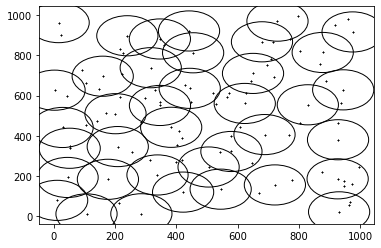

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def load_data(fileName):
    X = np.loadtxt(fileName, delimiter=' ');
    return X;
X = load_data("./centroid_blobs_ILP.txt")
centers = load_data("./centers_second.txt")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1], c='black', marker='x', s = 1)
print(len(centers))
for center in centers:
    disk1 = plt.Circle((center[0], center[1]), 100, color='black', fill=False)
    ax.add_artist(disk1)
plt.show();